In [341]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import json
from tabulate import tabulate
from sklearn.linear_model import LogisticRegression, LinearRegression


In [245]:
# magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [246]:
from dataset_creation import create_dataset

In [247]:
df = create_dataset()

In [248]:
df.columns

Index(['first_name', 'last_name', 'salary', 'salary_next_year', 'added_salary',
       'T', 'age_group', 'team_name', 'shots_per_game', 'goals_per_game',
       'pass_success', 'rating', 'minutes_per_game', 'age_group_next_year',
       'team_name_next_year', 'shots_per_game_next_year',
       'goals_per_game_next_year', 'pass_success_next_year',
       'rating_next_year', 'minutes_per_game_next_year'],
      dtype='object')

0.45168669037985365

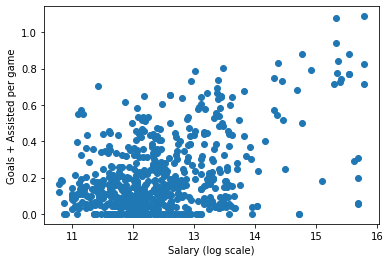

In [249]:
plt.scatter(df["salary_next_year"], df["goals_per_game_next_year"])
plt.xlabel("Salary (log scale)")
plt.ylabel("Goals + Assisted per game")
#  x log scale

# calc correlation
corr = df.corr()
corr.loc["salary_next_year", "goals_per_game_next_year"]


In [328]:
T = df["T"]
# X = pd.get_dummies(df[["salary_next_year", 
#                        "age_group_next_year",
#                        "team_name_next_year",
#                        "rating",
#                        "minutes_per_game_next_year",
#                        "pass_success_next_year",
#                        'shots_per_game_next_year',
#                        ]])

X = pd.get_dummies(df[[
                       "salary",
                    # "added_salary"
                    #    "salary_next_year", 
                       "age_group",
                       "team_name",
                       "team_name_next_year",
                       "rating",
                       "minutes_per_game",
                       "pass_success",
                       'shots_per_game',
                       ]])

Y = df["rating_next_year"]

/home/john/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


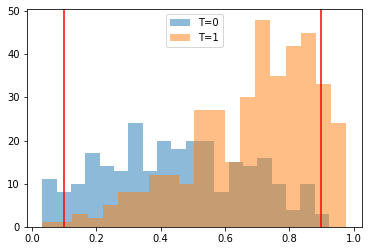

In [329]:
# calc propensity score
from sklearn.linear_model import LogisticRegression, LinearRegression

lr = LogisticRegression()
lr.fit(X, T)
ps = lr.predict_proba(X)[:, 1]

# visualize propensity score
plt.hist(ps[T == 0], bins=20, alpha=0.5, label="T=0")
plt.hist(ps[T == 1], bins=20, alpha=0.5, label="T=1")
plt.legend()


# x line
low_threshold = 0.1 
high_threshold = 0.9
plt.axvline(low_threshold, color="red")
plt.axvline(high_threshold, color="red")


In [330]:
# TODO: trim outliers based on propensity score

# trim outliers
X = X[(ps > low_threshold) & (ps < high_threshold)]
T = T[(ps > low_threshold) & (ps < high_threshold)]
Y = Y[(ps > low_threshold) & (ps < high_threshold)]
ps = ps[(ps > low_threshold) & (ps < high_threshold)]

Text(0.5, 1.0, 'Propensity score after trimming')

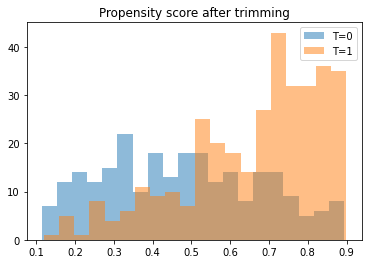

In [331]:
plt.hist(ps[T == 0], bins=20, alpha=0.5, label="T=0")
plt.hist(ps[T == 1], bins=20, alpha=0.5, label="T=1")
plt.legend()

plt.title("Propensity score after trimming")

In [332]:
data = X
data["T"] = T
data["Y"] = Y

In [346]:
def fit_model(data, out_var, ignore=None, max_iter=10000, model_type="logistic"):

    if ignore is None:
        ignore = []
    
    if model_type == "logistic":
        model = LogisticRegression(max_iter=max_iter)
    elif model_type == "linear":
        model = LinearRegression()
    elif isinstance(model_type, sklearn.base.BaseEstimator):
        model = model_type
    else:
        raise ValueError("model_type must be 'logistic' or 'linear'")

    X = data.drop([out_var] + ignore, axis=1)
    y = data[out_var]

    model.fit(X, y)

    return model

def propensity_fitting(data):

    propensity_func = fit_model(data, "T", ignore=["Y"], max_iter=10000)

    return propensity_func


def calc_propensity_score(data, propensity_func):
    X = data.drop(["T", "Y"], axis=1)
    propensity_score = propensity_func.predict_proba(X)[:, 1]
    propensity_score = pd.Series(propensity_score, index=X.index)

    return propensity_score

def IPW_ATE(Y, T, propensity_score):
    return (np.sum(Y[T == 1] / propensity_score[T == 1]) - np.sum(Y[T == 0] / propensity_score[T == 0])) / len(Y)

def calculate_IPW_ATE(data):
    propensity_func = propensity_fitting(data)
    propensity_score = calc_propensity_score(data, propensity_func)
    return IPW_ATE(data["Y"], data["T"], propensity_score)


# S-learner
def fit_y(data):

    y_func = fit_model(data, "Y", max_iter=10000, model_type="linear")

    return y_func

def covariate_adjustment(data, y1_func, y0_func=None):
    if y0_func is None:
        y0_func = y1_func

    X = data.drop(["Y"], axis=1)

    X1 = X.copy()
    X1["T"] = 1
    y1 = y1_func.predict(X1)

    X0 = X.copy()
    X0["T"] = 0
    y0 = y0_func.predict(X0)

    y = y1 - y0

    return y.mean()




def calculate_S_learner_ATE(data):

    y_func = fit_y(data)

    return covariate_adjustment(data, y_func)

# T-learner
def calculate_T_learner_ATE(data):

    y1_func = fit_y(data[data["T"] == 1])
    y0_func = fit_y(data[data["T"] == 0])

    return covariate_adjustment(data, y1_func, y0_func)

from sklearn.neighbors import NearestNeighbors
def calculate_matching_ATE(data, metric="euclidean"):

    knn0 = NearestNeighbors(n_neighbors=1, metric=metric)
    knn1 = NearestNeighbors(n_neighbors=1, metric=metric)

    X = data.drop(["Y", "T"], axis=1)

    knn0.fit(X[data["T"] == 0])
    knn1.fit(X[data["T"] == 1])

    X0 = X[data["T"] == 0]
    X1 = X[data["T"] == 1]

    _, idx0 = knn0.kneighbors(X1)
    _, idx1 = knn1.kneighbors(X0)

    y0 = data["Y"][data["T"] == 0].iloc[idx0[:, 0]]
    y1 = data["Y"][data["T"] == 1].iloc[idx1[:, 0]]

    y0 = data["Y"][data["T"] == 1] - y0
    y1 = y1 - data["Y"][data["T"] == 0]

    return (y0.sum() + y1.sum()) / (len(y0) + len(y1)) 






In [347]:

def calculate_ATE(data, method="IPW"):
    if method == "IPW":
        return calculate_IPW_ATE(data)
    elif method == "S-learner":
        return calculate_S_learner_ATE(data)
    elif method == "T-learner":
        return calculate_T_learner_ATE(data)
    elif method == "matching":
        return calculate_matching_ATE(data)
    else:
        raise ValueError("method must be 'IPW', 'S-learner', 'T-learner', or 'matching'")

# estimate variance using bootstrap
def estimate_variance(data, method="IPW", n_iter=1000, random_state=0, sample_size=None):
    np.random.seed(random_state)

    if sample_size is None:
        sample_size = len(data)

    ate_list = []
    for _ in range(n_iter):
        idx = np.random.choice(data.index, size=sample_size, replace=True)
        ate_list.append(calculate_ATE(data.loc[idx], method=method))

    ate_list = np.array(ate_list)
    return ate_list.std()



In [348]:
# tabulate all results
methods = ["IPW", "S-learner", "T-learner", "matching"]
results = pd.DataFrame(index=methods, columns=["ATE", "std"])

for method in methods:
    results.loc[method, "ATE"] = calculate_ATE(data, method=method)
    results.loc[method, "std"] = estimate_variance(data, method=method, n_iter=10, sample_size=100)
    # add 95% confidence interval
    results.loc[method, "ATE (95% CI)"] = f"{results.loc[method, 'ATE']:.3f} ± {1.96 * results.loc[method, 'std']:.3f}"

print(tabulate(results, headers="keys", tablefmt="github"))

|           |         ATE |       std | ATE (95% CI)   |
|-----------|-------------|-----------|----------------|
| IPW       | -1.06257    | 1.67357   | -1.063 ± 3.280 |
| S-learner | -0.0076345  | 0.0186351 | -0.008 ± 0.037 |
| T-learner | -0.00526635 | 0.0218868 | -0.005 ± 0.043 |
| matching  |  0.00252029 | 0.0292028 | 0.003 ± 0.057  |


In [345]:
Y.min()

6.186999999999999

In [252]:

X.shape

(656, 9)

In [130]:
# def read_mls_salaries(data_path, year):

#     salaries_year = pd.read_csv(os.path.join(data_path, f"mls-salaries-{year}.csv"))

#     salaries_year["salary"] = salaries_year["guaranteed_compensation"]

#     salaries_year = salaries_year[salaries_year["position"].str.contains("F") 
#                                   & (~salaries_year["position"].isna())]

#     salaries_year = salaries_year[["first_name", "last_name", "salary"]]

#     return salaries_year

# def read_stats_data(data_path, year):

#     stats_year = pd.read_json(os.path.join(data_path, f"data_{year}.json"))

#     stats_year["age_group"] = pd.cut(stats_year["age"], 
#                          bins=[20, 27, 30, 35, 100], 
#                          labels=["20-27", "27-30", "30-35", ">35"])

    
#     stats_year["goals_per_game"] = (stats_year["goal"] + stats_year["assistTotal"]) / stats_year["apps"]
#     stats_year["shots_per_game"] = stats_year["shotsPerGame"] # / stats_year["apps"]
#     stats_year["minutes_per_game"] = stats_year["minsPlayed"] / stats_year["apps"]

#     stats_year = stats_year.rename(columns={"teamName": "team_name",
#                                             "passSuccess": "pass_success",
#                                             "firstName": "first_name",
#                                             "lastName": "last_name"})

#     stats_year = stats_year[["age_group", 
#                              "team_name", 
#                              "shots_per_game", 
#                              "goals_per_game",
#                              "pass_success",
#                              "rating",
#                              "minutes_per_game",
#                              "first_name",
#                              "last_name"]]


#     # stats_year = pd.get_dummies(stats_year, columns=["age_group", "team_name"])


#     return stats_year



In [133]:
# def merge_datasets(year, data_path):
#     merge_on = ["last_name", "first_name"]


#     salaries_path = os.path.join(data_path, "csvs")

#     salaries_year = read_mls_salaries(salaries_path, year)
#     salaries_next_year = read_mls_salaries(salaries_path, year + 1)



#     # Merge the two datasets
#     salaries_merged = pd.merge(salaries_year, 
#                                salaries_next_year, 
#                                on=merge_on, 
#                                how="inner",
#                                suffixes=("", "_next_year"))


#     added_salary = (salaries_merged["salary_next_year"] - salaries_merged["salary"]) / salaries_merged["salary"] 
#     salaries_merged["added_salary"] = added_salary

#     salaries_merged = salaries_merged[salaries_merged["added_salary"] > -0.1]
#     salaries_merged["T"] = salaries_merged["added_salary"] > 0.1
    
#     stats_path = os.path.join(data_path, "jsons")

#     stats_year = read_stats_data(stats_path, year)
#     stats_next_year = read_stats_data(stats_path, year + 1)


#     # Merge the two datasets
#     stats_merged = pd.merge(stats_year,
#                             stats_next_year,    
#                             on=merge_on,
#                             how="inner",
#                             suffixes=("", "_next_year"))

    
#     a1 = salaries_merged.columns
#     a2 = stats_merged.columns
#     a3 = np.intersect1d(a1, a2)
#     a3 = a3[~np.isin(a3, merge_on)]

    
#     assert len(a3) == 0, "There are columns with the same name in both datasets"

#     # Merge the two datasets
#     merged = pd.merge(salaries_merged,
#                       stats_merged,
#                         on=merge_on,
#                         # left_on=["last_name", "first_name"],
#                         # right_on=["lastName", "firstName"],
#                         how="inner")

#     return merged
    



In [134]:
# df = pd.DataFrame()

# for year in range(2013, 2018):

#     # df = merge_datasets(year, "archive")
#     df = df.append(merge_datasets(year, "archive"))


In [135]:
df

,first_name,last_name,salary,salary_next_year,added_salary,T,age_group,team_name,shots_per_game,goals_per_game,pass_success,rating,minutes_per_game,age_group_next_year,team_name_next_year,shots_per_game_next_year,goals_per_game_next_year,pass_success_next_year,rating_next_year,minutes_per_game_next_year
0,Patrice,Bernier,162333.25,205000.00,0.262834,True,>35,Montreal,0.741935,0.290323,82.414393,7.101613,79.967742,>35,Montreal,0.423077,0.038462,83.318057,6.752692,69.346154
1,Deshorn,Brown,113000.00,123000.00,0.088496,False,30-35,Colorado,3.062500,0.406250,68.894009,6.750625,70.156250,30-35,Colorado,4.033333,0.333333,76.344086,6.833333,76.266667
2,Will,Bruin,165000.00,172500.00,0.045455,False,30-35,Houston,3.117647,0.500000,70.258621,6.912353,84.647059,30-35,Houston,2.518519,0.407407,70.967742,6.880000,76.888889
3,Edson,Buddle,275000.00,325000.00,0.181818,True,>35,Colorado,2.240000,0.320000,74.122807,6.681600,67.320000,>35,Colorado,1.833333,0.166667,72.625698,6.522778,62.000000
4,Conor,Casey,175000.00,192500.00,0.100000,False,>35,Philadelphia,2.064516,0.451613,64.664804,6.860968,71.193548,>35,Philadelphia,1.560000,0.360000,65.668203,6.734800,57.360000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Danny,Hoesen,503129.00,518000.00,0.029557,False,30-35,San Jose,2.181818,0.303030,71.381032,6.680303,58.454545,30-35,San Jose,2.441176,0.441176,70.902394,6.782059,73.176471
29,Chris,Wondolowski,800000.00,800000.00,0.000000,False,>35,San Jose,2.314286,0.600000,78.516903,6.874286,89.457143,>35,San Jose,1.705882,0.441176,74.611399,6.623529,67.352941
30,Sebastian,Giovinco,7115555.67,7115555.67,0.000000,False,>35,Toronto,4.862069,0.827586,72.928177,7.463793,83.482759,>35,Toronto,5.964286,0.714286,74.907749,7.535714,85.214286
31,Tosaint,Ricketts,193166.67,203174.67,0.051810,False,30-35,Toronto,1.434783,0.347826,69.189189,6.724348,47.478261,30-35,Toronto,1.111111,0.166667,79.104478,6.271111,33.500000


In [116]:
# added_salary = (df["guaranteed_compensation_next_year"] - df["guaranteed_compensation"]) / df["guaranteed_compensation"] 
# df["added_salary"] = added_salary

# df = df[df["added_salary"] > -0.1]
# df["T"] = df["added_salary"] > 0.1

# df = df[df["position"].str.contains("F")]

KeyError: 'guaranteed_compensation_next_year'

In [72]:
# df["T"].value_counts()

True     92
False    89
Name: T, dtype: int64

In [73]:
# df["shotsPerGame"]

13     0.741935
17     3.062500
18     3.117647
19     2.240000
28     2.064516
         ...   
120    2.181818
125    2.314286
129    4.862069
133    1.434783
138    1.285714
Name: shotsPerGame, Length: 181, dtype: float64

In [74]:
# df.position.value_counts()

F      144
M-F     17
F-M      9
M/F      9
D/F      2
Name: position, dtype: int64

In [75]:
# df["shotsPerGame"].hist()

In [76]:
# [col for col in df.columns if "next_year" not in col]

['club',
 'last_name',
 'first_name',
 'position',
 'base_salary',
 'guaranteed_compensation',
 'height',
 'weight',
 'age',
 'isManOfTheMatch',
 'isActive',
 'playedPositions',
 'playedPositionsShort',
 'teamRegionName',
 'regionCode',
 'tournamentShortName',
 'apps',
 'subOn',
 'manOfTheMatch',
 'goal',
 'assistTotal',
 'shotsPerGame',
 'aerialWonPerGame',
 'name',
 'firstName',
 'lastName',
 'playerId',
 'positionText',
 'teamId',
 'teamName',
 'seasonId',
 'seasonName',
 'isOpta',
 'tournamentId',
 'tournamentRegionId',
 'tournamentRegionCode',
 'tournamentRegionName',
 'tournamentName',
 'rating',
 'minsPlayed',
 'yellowCard',
 'redCard',
 'passSuccess',
 'ranking',
 'added_salary',
 'T']

In [77]:
# df["first_name"]

13       Patrice
17       Deshorn
18          Will
19         Edson
28         Conor
         ...    
120        Danny
125        Chris
129    Sebastian
133      Tosaint
138        Yordy
Name: first_name, Length: 181, dtype: object

In [78]:
df["club"].unique()

array(['MTL', 'COL', 'HOU', 'PHI', 'DAL', 'SJ', 'LA', 'KC', 'SEA', 'NE',
       'CLB', 'NY', 'POR', 'VAN', 'CHI', 'RSL', 'DC', 'TOR', 'CHV', 'ORL',
       'NYCFC', 'NYRB'], dtype=object)

In [79]:
df["teamName"].unique()

array(['Montreal', 'Colorado', 'Houston', 'Philadelphia', 'FC Dallas',
       'San Jose', 'L.A. Galaxy', 'Kansas City', 'Seattle', 'New England',
       'Columbus', 'New York', 'Portland', 'Vancouver', 'Chicago',
       'Salt Lake', 'DC United', 'Toronto', 'Chivas', 'Orlando City',
       'New York City FC'], dtype=object)

In [80]:
df[df["club"] == "NY"]["teamName"].unique()

array(['New York'], dtype=object)

In [81]:
# age groups
# 20 - 27
# 27 - 30
# 30 - 35
# 35 - 100


                         

In [82]:
df["goals_normalized"] = (df["goal"] + df["assistTotal"]) / df["apps"]
df["shotsPerGame"] = df["shotsPerGame"] / df["apps"]